# Alzheimer's disease Classification

The focus of this notebook is to train models for Alzheimer's classification with three disease levels: Very Mild, Mild, and Moderate. The number of images for each level is imbalanced, with the No Disease class having the most images and the Moderate disease class having the fewest. The baseline accuracy is 50%.
[Study](https://www.medscape.com/viewarticle/883192) showed that Alzheimer's disease classification from MRI scans by medical professionals archives accuracy  around 75%. I will use CNN models and pre-trained models, such as EfficientNetV2S, Xception, and ResNet50. I will also apply class weights to the best model to address the issue of imbalanced classes.

In [4]:
# Imports
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2S, Xception, resnet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import functions

import numpy as np
np.random.seed(18)

In [3]:
# The path to the training and testing sets
al_path_train = '../data/alzheimer/train'
al_path_test = '../data/alzheimer/test'

# Set image size
image_size = 240

# Set optimizer
learning_rate = 0.001 
optimizer = Adam(learning_rate=learning_rate)

# Set Early stopping
es = EarlyStopping(patience = 5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

## CNN model

In [4]:
# Load data fror training
al_train_ds, al_val_ds = image_dataset_from_directory(
    al_path_train,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',  # The images are black and wight
    batch_size=64,
    image_size=(image_size, image_size),
    seed=18,
    validation_split=0.2,
    subset = 'both'
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Using 1024 files for validation.


In [5]:
# Load data for Testing
al_test_ds = image_dataset_from_directory(
    al_path_test,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',  # The images are black and wight
    batch_size=64,
    image_size=(image_size, image_size),
    seed=18
)

Found 1279 files belonging to 4 classes.


In [7]:
model = Sequential()

model.add(layers.Input(shape=(image_size, image_size, 1)))
model.add(layers.Rescaling(1./255))

#First Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#Second Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#Third Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#Fourth Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Flatten
model.add(Flatten())
# Fully Connected
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h = model.fit(al_train_ds, validation_data = al_val_ds, epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
65/65 [==============================] - 220s 3s/step - loss: 1.1269 - accuracy: 0.4686 - val_loss: 1.1744 - val_accuracy: 0.5107 - lr: 0.0010
Epoch 2/30
65/65 [==============================] - 225s 3s/step - loss: 1.0746 - accuracy: 0.4794 - val_loss: 1.1508 - val_accuracy: 0.5107 - lr: 0.0010
Epoch 3/30
65/65 [==============================] - 223s 3s/step - loss: 1.0607 - accuracy: 0.4838 - val_loss: 1.0133 - val_accuracy: 0.5107 - lr: 0.0010
Epoch 4/30
65/65 [==============================] - 222s 3s/step - loss: 1.0129 - accuracy: 0.5172 - val_loss: 0.9399 - val_accuracy: 0.5430 - lr: 0.0010
Epoch 5/30
65/65 [==============================] - 216s 3s/step - loss: 0.9491 - accuracy: 0.5502 - val_loss: 0.9561 - val_accuracy: 0.5547 - lr: 0.0010
Epoch 6/30
65/65 [==============================] - 180s 3s/step - loss: 0.9156 - accuracy: 0.5763 - val_loss: 0.8986 - val_accuracy: 0.5664 - lr: 0.0010
Epoch 7/30
65/65 [==============================] - 135s 2s/step - loss: 0.9

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 240, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 119, 119, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                    

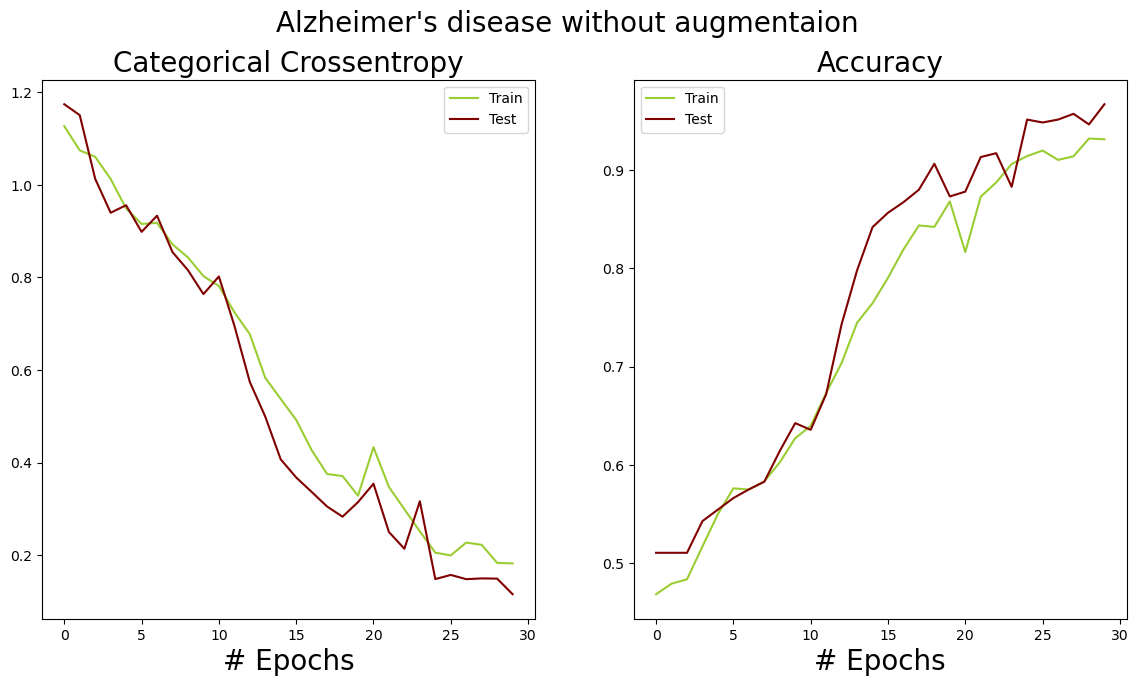

In [10]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h, 'Alzheimer\'s disease without augmentaion')

Accuracy_score: 0.9668 



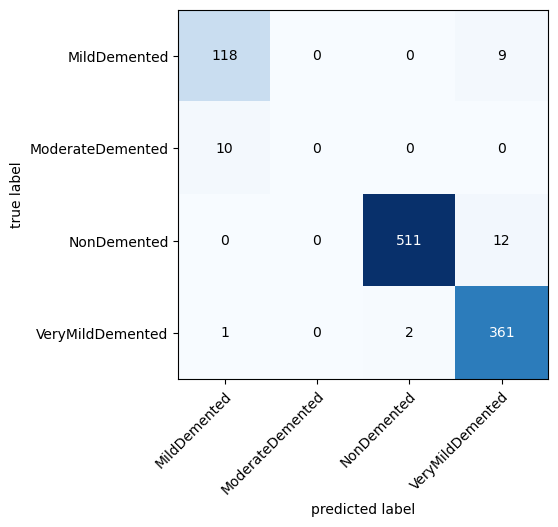

In [9]:
# Plot Confusion Matrix for Validation set
functions.acc_conf_matrix(model, val_data=al_val_ds)

Accuracy_score: 0.6747 



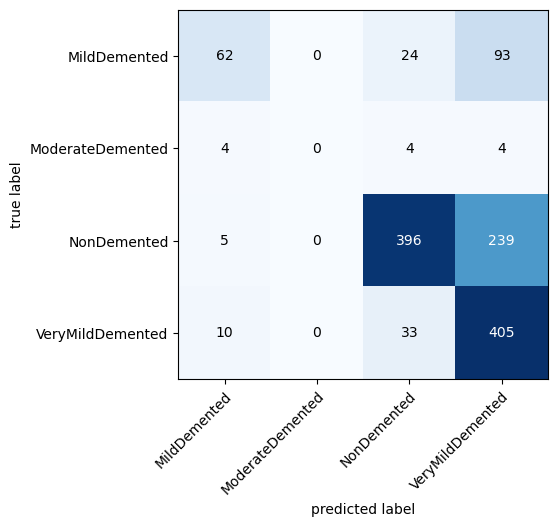

In [8]:
# Plot Confusion Matrix for Testing data
functions.acc_conf_matrix(model, val_data=al_test_ds)

The model performs well on the validating set, except Moderate Alzheimer's. The model does not perform great on the test set, it is overfit. I have tried different Dropouts, learning rate and regularizations and this is my best model. The worst predicted is Modetate Demented. 

---

# Pre-trained models

Pre-trained models require color images I will have to read the images separately and convert each to RGB. Inspired by [article](https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images) 

In [11]:
# Read the images, convert to grayscale and prepare for Tensorflow models
X_train, X_val, y_train, y_val = functions.read_gray_images_to_rgb(al_path_train)

# Check the shape of the data
X_train.shape, y_train.shape

((3840, 240, 240, 3), (3840, 4))

In [12]:
# Prepare the training data for predictions
X_test, y_test = functions.read_gray_images_to_rgb(al_path_test, train_test = False)

# Check the shape of the data
X_test.shape, y_test.shape

((1279, 240, 240, 3), (1279, 4))

---

## EfficientNetV2S

In [61]:
effnet = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax",
    include_preprocessing=True,
)

In [62]:
# Freeze last 5 layers
for layer in effnet.layers[:-5]:
    layer.trainable = False

In [63]:
# Read images and convert each to RGB
model = Sequential()
model.add(effnet)
model.add(GlobalAveragePooling2D())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_efv2s = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
120/120 [==============================] - 416s 3s/step - loss: 0.9536 - accuracy: 0.5695 - val_loss: 0.8548 - val_accuracy: 0.5847 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 408s 3s/step - loss: 0.8052 - accuracy: 0.6352 - val_loss: 0.7559 - val_accuracy: 0.6386 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 407s 3s/step - loss: 0.7465 - accuracy: 0.6654 - val_loss: 0.7160 - val_accuracy: 0.6721 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 422s 4s/step - loss: 0.7101 - accuracy: 0.6849 - val_loss: 0.6830 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 391s 3s/step - loss: 0.6611 - accuracy: 0.7156 - val_loss: 0.6910 - val_accuracy: 0.6940 - lr: 0.0010
Epoch 6/30
120/120 [==============================] - 288s 2s/step - loss: 0.6476 - accuracy: 0.7177 - val_loss: 0.6934 - val_accuracy: 0.6877 - lr: 0.0010
Epoch 7/30
120/120 [==============================] - 356s 3s/st

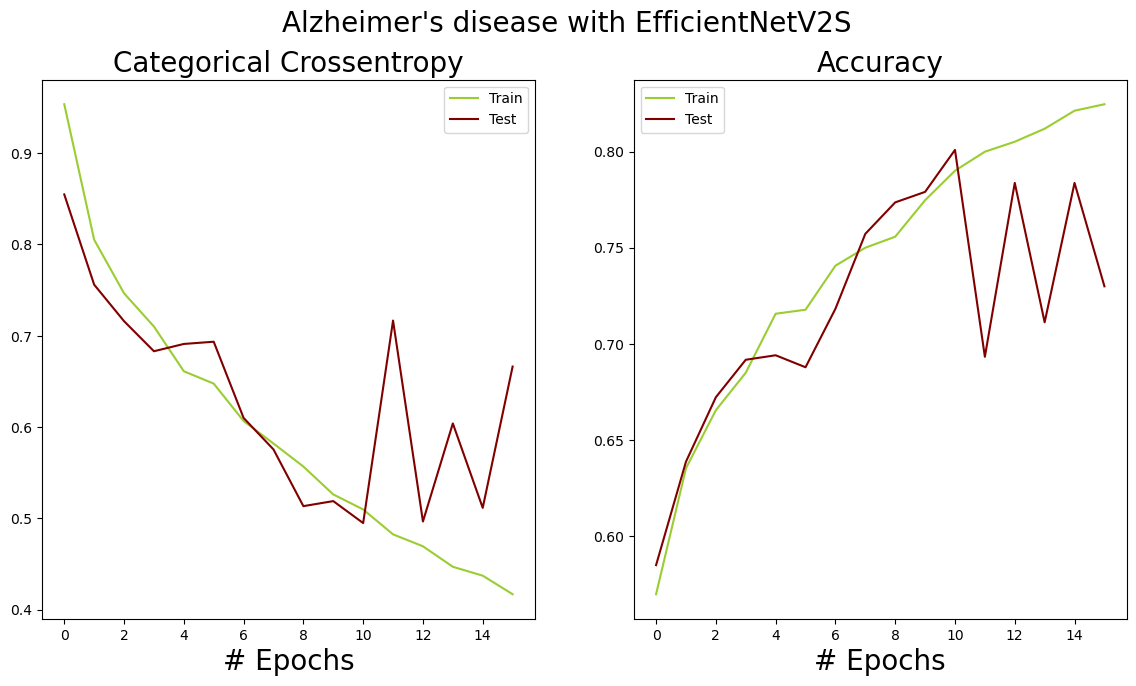

In [64]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_efv2s, 'Alzheimer\'s disease with EfficientNetV2S')

Accuracy_score: 0.8009 



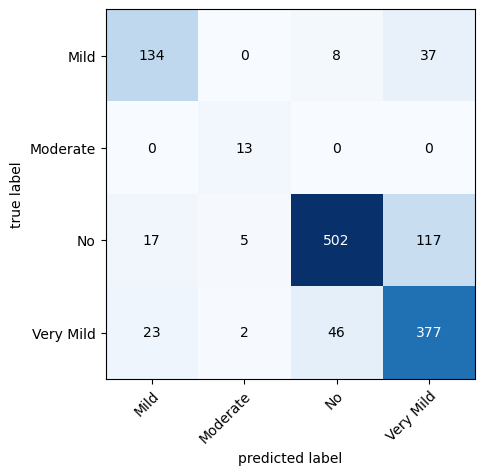

In [65]:
# Validating set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Accuracy_score: 0.6458 



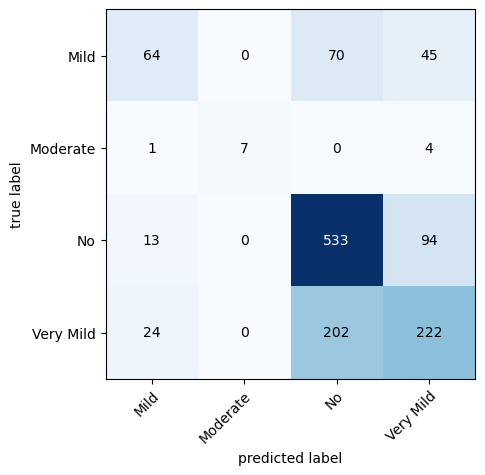

In [66]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

EfficientNetV2S with images converted to RGB has accuracy lower than the CNN model on grayscale images

---

## Xception

In [53]:
xception_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax"
)

In [54]:
# Freeze last 5 layers
for layer in xception_model.layers[:-5]:
    layer.trainable = False

In [56]:
# Read images and convert each to RGB
model = Sequential()
model.add(xception_model)
model.add(GlobalAveragePooling2D())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_xc = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
120/120 [==============================] - 561s 4s/step - loss: 0.8910 - accuracy: 0.5820 - val_loss: 1.2167 - val_accuracy: 0.5839 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 412s 3s/step - loss: 0.7567 - accuracy: 0.6602 - val_loss: 1.0527 - val_accuracy: 0.5597 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 365s 3s/step - loss: 0.6554 - accuracy: 0.7115 - val_loss: 0.9665 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 380s 3s/step - loss: 0.5616 - accuracy: 0.7628 - val_loss: 0.9122 - val_accuracy: 0.6315 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 364s 3s/step - loss: 0.4437 - accuracy: 0.8203 - val_loss: 0.8065 - val_accuracy: 0.6643 - lr: 0.0010
Epoch 6/30
120/120 [==============================] - 380s 3s/step - loss: 0.3793 - accuracy: 0.8513 - val_loss: 0.6742 - val_accuracy: 0.7166 - lr: 0.0010
Epoch 7/30
120/120 [==============================] - 297s 2s/st

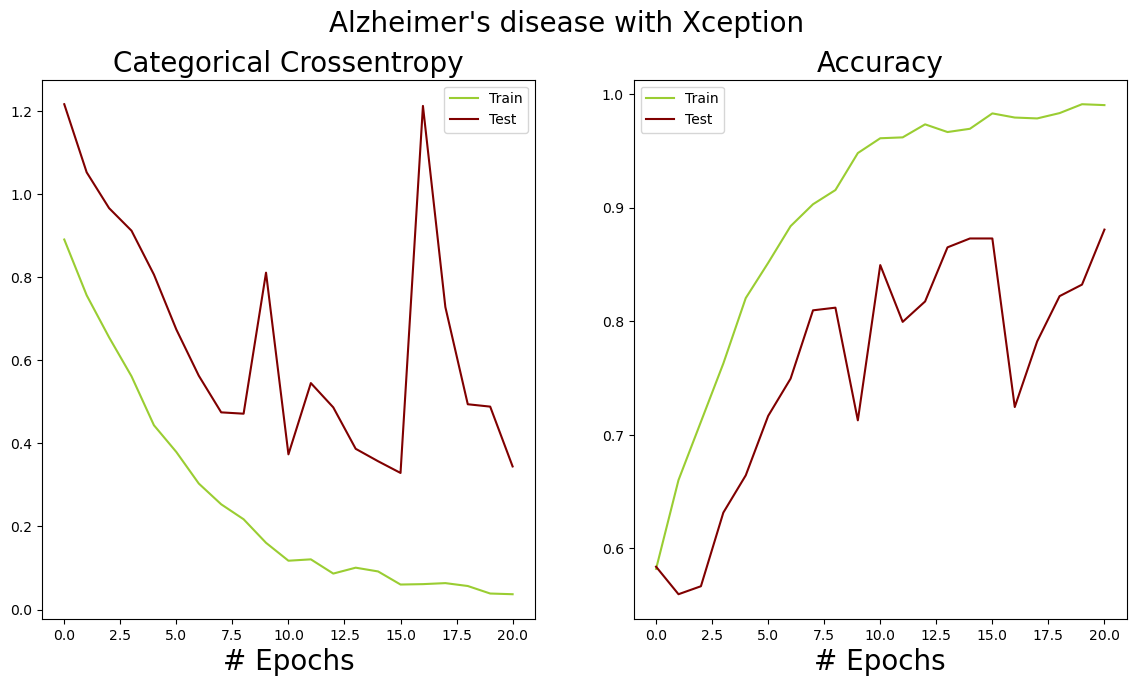

In [57]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_xc, 'Alzheimer\'s disease with Xception')

Accuracy_score: 0.8728 



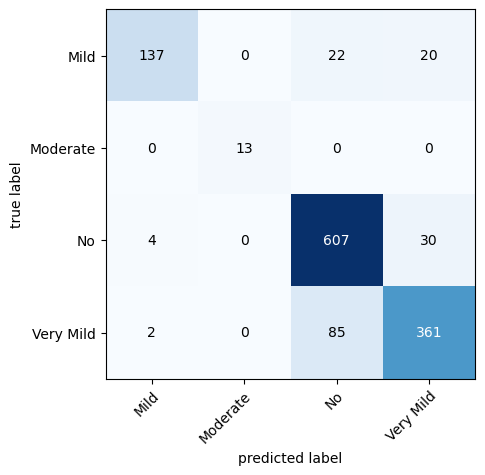

In [59]:
# Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

This model struggles to classify Very Mild Alzheimer.

Accuracy_score: 0.5942 



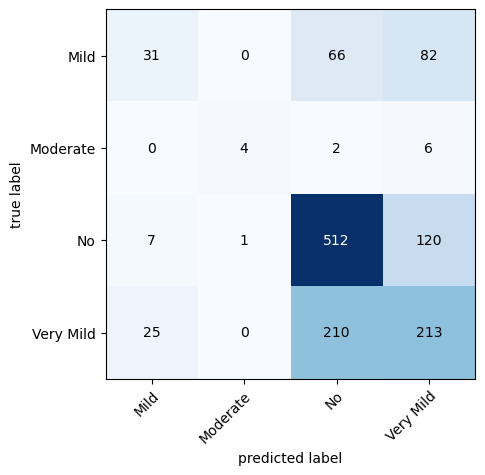

In [60]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Xception with images transformed to RBG has lower accuracy than EfficientNetV2S. The Xception model has the lowest accuracy of all models I have tried.

### ResNet50

In [28]:
rn_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax"
)

In [29]:
for layer in rn_model.layers:
    layer.trainable = False

In [35]:
# Read the images, convert to grayscale and prepare for Tensorflow models
X_train, X_val, y_train, y_val = read_gray_images_to_rgb(al_path_train)

# Check the shape of the data
X_train.shape, y_train.shape

((3840, 240, 240, 3), (3840, 4))

In [38]:
# Prepare the training data for predictions
X_test, y_test = read_gray_images_to_rgb(al_path_test, train_test = False)

# Check the shape of the data
X_test.shape, y_test.shape

((1279, 240, 240, 3), (1279, 4))

In [36]:
# Read images and convert each to RGB
model = Sequential()
model.add(rn_model)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
120/120 [==============================] - 180s 1s/step - loss: 5.7574 - accuracy: 0.6151 - val_loss: 1.6532 - val_accuracy: 0.7455 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 173s 1s/step - loss: 0.7794 - accuracy: 0.8427 - val_loss: 1.0654 - val_accuracy: 0.7994 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 175s 1s/step - loss: 1.4284 - accuracy: 0.8104 - val_loss: 2.3053 - val_accuracy: 0.7463 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 172s 1s/step - loss: 0.6846 - accuracy: 0.9068 - val_loss: 1.6233 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 177s 1s/step - loss: 0.2468 - accuracy: 0.9557 - val_loss: 0.7426 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 6/30
120/120 [==============================] - 224s 2s/step - loss: 0.1548 - accuracy: 0.9706 - val_loss: 0.5979 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 7/30
120/120 [==============================] - 251s 2s/st

Accuracy_score: 0.6747 



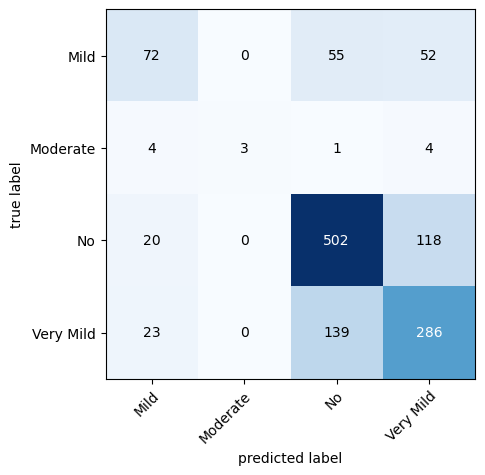

In [39]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

The ResNet50 model have the highest scores from all my pre-trained models.

## Apply class weigths
My data is extremely imbalanced and I will try to combat it by applying class weights. Inspired by 
[article](https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras) 

In [45]:
# Read the images, convert to grayscale and prepare for Tensorflow models
X_train, X_val, y_train, y_val, class_weights = functions.read_gray_images_to_rgb(al_path_train, weights = True)

In [48]:
# Read images and convert each to RGB
model = Sequential()
model.add(rn_model)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(X_train, y_train, validation_data = (X_val, y_val), class_weight=weights_dict, epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
120/120 [==============================] - 273s 2s/step - loss: 13.6334 - accuracy: 0.4734 - val_loss: 8.0728 - val_accuracy: 0.4949 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 263s 2s/step - loss: 1.6801 - accuracy: 0.7737 - val_loss: 2.2024 - val_accuracy: 0.7244 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 259s 2s/step - loss: 1.3064 - accuracy: 0.8135 - val_loss: 1.6086 - val_accuracy: 0.7510 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 257s 2s/step - loss: 0.3861 - accuracy: 0.8893 - val_loss: 1.2365 - val_accuracy: 0.8009 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 259s 2s/step - loss: 0.1230 - accuracy: 0.9526 - val_loss: 0.7371 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 6/30
120/120 [==============================] - 254s 2s/step - loss: 0.0489 - accuracy: 0.9810 - val_loss: 1.0080 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 7/30
120/120 [==============================] - 205s 2s/s

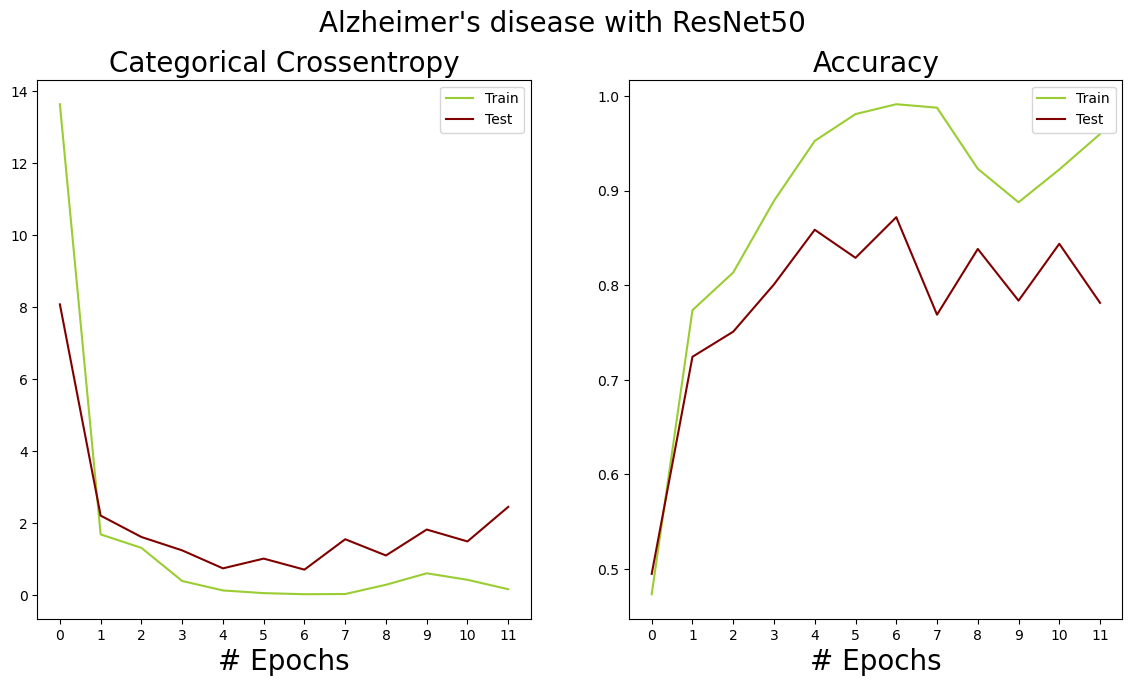

In [50]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_rn, 'Alzheimer\'s disease with ResNet50')

Accuracy_score: 0.872 



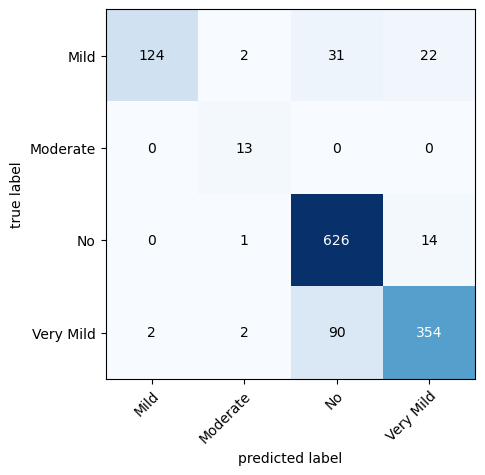

In [51]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Accuracy_score: 0.6403 



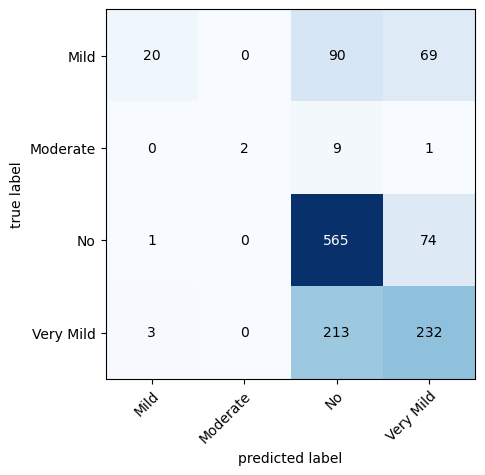

In [49]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

The model accuracy got from 67% to 64%. Adding weights did not improve my model.

---

The ResNet50 model achieved the highest accuracy among the three pre-trained models tested, at around 67%. However, there was a significant gap between the validation/training accuracies and the test accuracy, indicating overfitting. The Xception model performed poorly on this dataset. Applying class weights did not improve the model accuracy. In the next notebook, I will evaluate the same models on the Brain Tumor dataset.